<a href="https://colab.research.google.com/github/Maya7991/gsc_classification/blob/main/snn_conv2d_mel_multiencoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snntorch --quiet
!pip install torchaudio --quiet

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T

from snntorch import spikegen, surrogate, functional as SF
import snntorch as snn

In [ ]:
# === CONFIGURATION ===
batch_size = 64
num_epochs = 10
learning_rate = 1e-4
num_steps = 25
encoding_type = 'ttfs'  # or 'ttfs'
save_model_path = f"snn_speech_{encoding_type}.pt"
loss_log_path = f"loss_log_{encoding_type}.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === DATASET ===
train_dataset = SPEECHCOMMANDS("./", download=True, subset="training")
val_dataset = SPEECHCOMMANDS("./", download=True, subset="validation")
test_dataset = SPEECHCOMMANDS("./", download=True, subset="testing")

In [ ]:
# === Label Encoding ===
all_labels = sorted(set(datapoint[2] for datapoint in train_dataset + val_dataset + test_dataset))
label_encoder = LabelEncoder()
label_encoder.fit(all_labels) # encode labels as indices

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=400,
    hop_length=160,
    n_mels=64  # Recommended to avoid warnings
)
target_length = 16000

def collate_fn(batch):
    tensors, targets = [], []

    for waveform, sample_rate, label, *_ in batch:
      if waveform.size(1) < target_length:
          pad_size = target_length - waveform.size(1)
          waveform = F.pad(waveform, (0, pad_size))
      else:
          waveform = waveform[:, :target_length]

      mel_spec = mel_transform(waveform).squeeze(0)  # Shape: [1, n_mels, time] squeezed to Shape: [n_mels, time] , useful for normalization
      if encoding_type == 'ttfs':
          # Min-max normalize to [0, 1] for latency encoding
          mel_spec = mel_spec - mel_spec.min()
          mel_spec = mel_spec / (mel_spec.max() + 1e-6)
      else:
          # Mean-std normalization for rate encoding
            mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-5)
      mel_spec = mel_spec.unsqueeze(0)  # Shape: [1, n_mels, time]
      tensors.append(mel_spec)  # [1, 64, 256]
      encoded_label = label_encoder.transform([label])[0]
      targets.append(encoded_label)

    return torch.stack(tensors), torch.tensor(targets)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# === Label Info for Model Output ===
num_classes = len(label_encoder.classes_)

torch.Size([1, 64, 101])
torch.Size([])


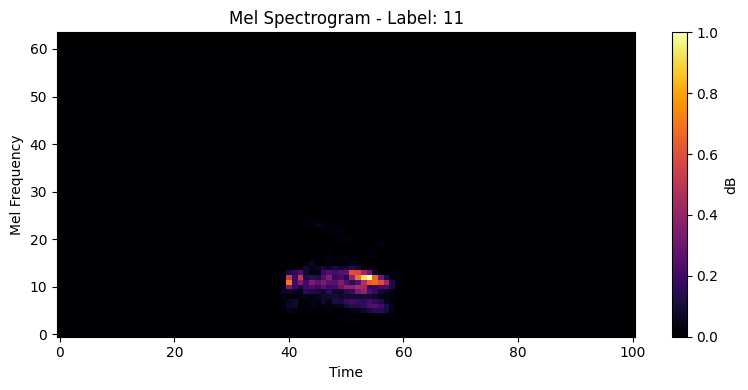

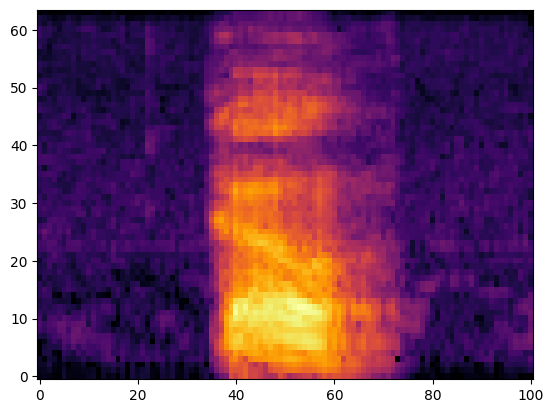

In [ ]:
for data, label in train_loader:
  print(data[0].shape)
  print(label[0].shape)
  mel_spec = data[0].squeeze().numpy()  # shape: [64, 32] → [mel, time]
  break

plt.figure(figsize=(8, 4))
plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="dB")
plt.title(f"Mel Spectrogram - Label: {label[0].item()}")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.tight_layout()
plt.show()

db_spec = torchaudio.transforms.AmplitudeToDB()(data[0])
plt.imshow(db_spec.squeeze().numpy(), cmap='inferno', aspect='auto', origin='lower')

In [ ]:

# === Label Info for Model Output ===
num_classes = len(label_encoder.classes_)
# encoding_type = 'ttfs'

# === MODEL ===
class SNNConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        beta = 0.95
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)
        self.lif1 = snn.Leaky(beta=beta)
        self.conv2 = nn.Conv2d(12, 32, kernel_size=5)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc1 = nn.Linear(32*286, 100)
        self.lif3 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(100, num_classes)
        self.lif4 = snn.Leaky(beta=beta)

    def forward(self, x, num_steps):
        spk_out_rec = []
        self.lif1.reset_mem()
        self.lif2.reset_mem()
        self.lif3.reset_mem()
        self.lif4.reset_mem()

        cur_input = encode_input(x, num_steps)
        for step in range(num_steps):
            cur1 = self.conv1(cur_input[step])
            cur1 = nn.functional.max_pool2d(cur1, kernel_size=2)
            spk1, _ = self.lif1(cur1)
            # spk1_rec.append(spk1)

            cur2 = self.conv2(spk1)
            cur2 = nn.functional.max_pool2d(cur2, kernel_size=2)
            spk2, _ = self.lif2(cur2)
            # spk2_rec.append(spk2)

            flat = spk2.view(spk2.size(0), -1)
            cur3 = self.fc1(flat)
            spk3, _ = self.lif3(cur3)
            # spk3_rec.append(spk3)

            cur_out = self.fc2(spk3)
            spk_out, _ = self.lif4(cur_out)
            spk_out_rec.append(spk_out)

        return torch.stack(spk_out_rec)

# === ENCODING ===
def encode_input(x, num_steps):
    if encoding_type == 'rate':
        return spikegen.rate(x, num_steps=num_steps)
    elif encoding_type == 'ttfs':
        return spikegen.latency(x, num_steps=num_steps, normalize=True, linear=True)
    else:
        raise ValueError("Unknown encoding type")

# === LOSS & ACCURACY ===
if encoding_type == 'rate':
    loss_fn = SF.ce_rate_loss()
    accuracy_fn = SF.accuracy_rate
elif encoding_type == 'ttfs':
    loss_fn = SF.ce_temporal_loss()
    accuracy_fn = SF.accuracy_temporal

# === TRAINING UTILS ===
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_acc = 0

    for batch in loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        spk_out = model(x, num_steps)
        loss = loss_fn(spk_out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        acc = accuracy_fn(spk_out, y)
        total_acc += acc

    return total_loss / len(loader), total_acc / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for batch in loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            spk_out = model(x, num_steps)
            loss = loss_fn(spk_out, y)
            acc = accuracy_fn(spk_out, y)

            total_loss += loss.item()
            total_acc += acc

    return total_loss / len(loader), total_acc / len(loader)

# === RUN TRAINING ===
model = SNNConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

log = []

best_val_acc = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Acc: {100*train_acc:.2f} | Val Loss: {val_loss:.4f}, Acc: {100*val_acc:.2f}%")
    log.append({'epoch': epoch + 1, 'train_loss': train_loss, 'val_loss': val_loss, 'train_acc': train_acc, 'val_acc': val_acc})

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_model_path)

# Save loss log
df = pd.DataFrame(log)
df.to_csv(loss_log_path, index=False)

# === FINAL TEST EVALUATION ===
model.load_state_dict(torch.load(save_model_path))
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 1 | Train Loss: 3.3328, Acc: 12.51 | Val Loss: 2.7227, Acc: 18.62
Epoch 2 | Train Loss: 2.6812, Acc: 20.83 | Val Loss: 2.5804, Acc: 21.92
Epoch 3 | Train Loss: 2.5323, Acc: 24.48 | Val Loss: 2.5209, Acc: 26.46
Epoch 4 | Train Loss: 2.3893, Acc: 28.66 | Val Loss: 2.3882, Acc: 28.06
Epoch 5 | Train Loss: 2.3117, Acc: 29.52 | Val Loss: 2.2867, Acc: 29.72
Epoch 6 | Train Loss: 2.2189, Acc: 31.33 | Val Loss: 2.2225, Acc: 30.81
Epoch 7 | Train Loss: 2.1558, Acc: 33.02 | Val Loss: 2.1774, Acc: 31.88


In [ ]:
db_spec = torchaudio.transforms.AmplitudeToDB()(data[0])
plt.imshow(db_spec.squeeze().numpy(), cmap='inferno', aspect='auto', origin='lower')